In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import csv
from tqdm import tqdm

In [2]:
def eul2rotm_ypr(euler):
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(euler[0]),-np.sin(euler[0])],
                    [0, np.sin(euler[0]), np.cos(euler[0])]], dtype=np.float32)
  
    R_y = np.array([[ np.cos(euler[1]), 0, np.sin(euler[1])],
                    [0, 1, 0 ],
                    [-np.sin(euler[1]), 0, np.cos(euler[1])]], dtype=np.float32)
  
    R_z = np.array([[np.cos(euler[2]),-np.sin(euler[2]), 0],
                    [np.sin(euler[2]), np.cos(euler[2]), 0],
                    [0, 0, 1]], dtype=np.float32)
                   
    return np.dot(R_z, np.dot(R_x, R_y))

def compute_hl_np(hl, sz, eps=1e-6):
    (a,b,c) = hl
    if b < 0:
        a, b, c = -a, -b, -c
    b = np.maximum(b, eps)
    
    left = np.array([-1.0, (a - c)/b])        
    right = np.array([1.0, (-a - c)/b])

    # scale back to original image    
    scale = sz[1]/2
    left = scale*left
    right = scale*right
    return [np.squeeze(left), np.squeeze(right)]

In [3]:
def parse_annot(annot):
    '''
    annot: [fn_img, fn_csv, yaw, pitch, roll, focal]
    '''
    filepath = os.path.join(root_db, annot[0])
    img = cv2.imread(filepath)
    assert img is not None, print(filepath)
    
    hh, ww = img.shape[:2]
    cx, cy = (ww / 2.0, hh / 2.0)
    
    with open(os.path.join(root_db, annot[1]), 'r') as fh:
        annot_lines = fh.read().splitlines()
    annot_lines = [a.split(',') for a in annot_lines]
    annot_lines = np.array(annot_lines).astype(float)
    annot_lines[:, 0::2] -= cx
    annot_lines[:, 1::2] -= cy
    
    n_seg = len(annot_lines)
    
    p0 = np.hstack([annot_lines[:, :2], np.ones([n_seg, 1])])
    p1 = np.hstack([annot_lines[:, 2:], np.ones([n_seg, 1])])
    
#     leqs = np.cross(p0, p1, axis=1)
#     lens = np.linalg.norm(p1 - p0, axis=1)
    
    pitch = np.radians(float(annot[3]))
    roll = np.radians(float(annot[4]))
    focal = float(annot[5])
    
    R = eul2rotm_ypr([pitch, 0, roll])
    R[1, :] = -R[1, :]
    K = np.array([[focal, 0, 0], [0, focal, 0], [0, 0, 1]])
    KR = np.dot(K, R)
    V = np.dot(KR, np.eye(3))
    
    zeni = V[:, 1] / np.maximum(V[2, 1], 1e-08)
    hori = np.cross(V[:, 0], V[:, 2])
    
    rho = 2.0/np.minimum(ww,hh)
    focal = rho*focal
    
    up_vector = R[:,1]
    hl = up_vector.copy()
    hl[2] = focal*hl[2]
    
    return zeni, hori, p0, p1, KR, hl # (zenith, horizon, line equtions, line lengths)

In [4]:
def sample_vps(p0, p1, hori, zeni, KR, n_samples, image=None, hl=None):
    '''
    '''
    lens = np.linalg.norm(p1 - p0, axis=1)
    
    if image is not None:
        h,w = image.shape[:2]
        lowtone_img = image[:,:,::-1]//2 + 128
        
        hl_pts = compute_hl_np(hl, (h,w))
        
        pts0 = p0.copy()
        pts1 = p1.copy()
    
    if image is not None:
        plt.figure(figsize=(8,8))
        plt.imshow(lowtone_img, extent=[-w/2, w/2, h/2, -h/2])
        plt.plot([pts0[:,0], pts1[:,0]], [pts0[:,1], pts1[:,1]], '-r')
        plt.plot([hl_pts[0][0], hl_pts[1][0]], 
                 [hl_pts[0][1], hl_pts[1][1]], '-', color='lime')

        plt.xlim(-w/2, w/2)
        plt.xlim(h/2, -h/2)
        plt.axis('off')
        plt.savefig('a.png', pad_inches=0, bbox_inches='tight')
        plt.close()
    
    # we work in 3d
    p0 = np.linalg.solve(KR, p0.T).T
    p1 = np.linalg.solve(KR, p1.T).T
    leqs = np.cross(p0, p1)
    leqs /= np.linalg.norm(leqs, axis=1)[:, np.newaxis]
    
    zeni = np.array([0, 1, 0])
    
    total_len = np.sum(lens)
    
    n_lines = len(leqs)
    
    idx0 = np.random.choice(n_lines, n_lines*10, replace=True)
    idx1 = np.random.choice(n_lines, n_lines*10, replace=True)
    vps = np.cross(leqs[idx0, :], leqs[idx1, :], axis=1)
    
    # filter out zero values
    is_valid = np.linalg.norm(vps, axis=1) > 1e-09
    vps = vps[is_valid, :]
    
    # sample n_samples points
    vps = vps[:n_samples, :]
    vps /= np.linalg.norm(vps, axis=1)[:, np.newaxis]
    
    # make all the vps in front of the camera
    is_neg = vps[:, 2] < 0
    vps[is_neg, :] *= -1
    
    # vps that are near horizon
    adists = np.abs(np.dot(vps, zeni))
    th_angle = np.cos(np.radians(87.5))
    is_near = adists < th_angle
    vps = vps[is_near, :]
    
    # lineseg-vps distances
    is_in_all = []
    for vp in vps:
        dd = np.abs(np.dot(leqs, vp))
        is_in_all.append(dd < th_angle)
    
    # remove vertical lines
    dd = np.abs(np.dot(leqs, zeni))
    not_zeni = dd < np.cos(np.radians(2.5))
    
    # sample vps
    is_in_all = np.transpose(np.array(is_in_all)) # (n_lines, n_vp)
    is_in_all = np.logical_and(is_in_all, not_zeni[:, np.newaxis])
    lens_all = is_in_all * lens[:, np.newaxis]
    sum_lens = np.sum(lens_all, axis=0)

    res = []
    for ii in range(2):
        midx = np.argmax(sum_lens)
        res.append(vps[midx, :])
        
        if image is not None:
            plt.figure(figsize=(8,8))
            plt.imshow(lowtone_img, extent=[-w/2, w/2, h/2, -h/2])
            plt.plot([pts0[is_in_all[:,midx],0], pts1[is_in_all[:,midx],0]], 
                     [pts0[is_in_all[:,midx],1], pts1[is_in_all[:,midx],1]], '-r')
            plt.xlim(-w/2, w/2)
            plt.xlim(h/2, -h/2)
            plt.axis('off')
            plt.savefig(f'a_{ii}.png', pad_inches=0, bbox_inches='tight')
            plt.close()
        
        is_in_all = np.logical_and(is_in_all, np.logical_not(is_in_all[:, midx:midx+1]))
        dist_angle = np.dot(vps, vps[midx, :])
        is_in_all = np.logical_and(is_in_all, dist_angle < np.cos(np.radians(60)))
        lens_all = is_in_all * lens_all
        sum_lens = np.sum(lens_all, axis=0)
        
    res = np.dot(KR, np.array(res).T).T
    return res / res[:, 2:]

In [5]:
root_db = '/data/project/rw/google_street_view_191210/manhattan/'

In [6]:
with open('gsv_test_20210313.csv', 'r') as fh:
    annots_all = fh.read().splitlines()

In [7]:
annots_all = [l.split(',') for l in annots_all]

In [8]:
zeni, hori, p0, p1, KR, hl = parse_annot(annots_all[8])
img = cv2.imread(os.path.join(root_db, annots_all[8][0]))

In [9]:
vps = sample_vps(p0, p1, hori, zeni, KR, 2000, img, hl)
cx, cy = (img.shape[1] / 2.0, img.shape[0] / 2.0)
vps[:, 0] += cx
vps[:, 1] += cy
if vps[0, 0] > vps[1, 0]:
    vps = vps[::-1, :]

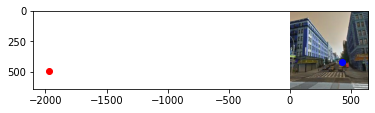

In [10]:
plt.imshow(img)
plt.plot(vps[0,0], vps[0,1], 'ro')
plt.plot(vps[1,0], vps[1,1], 'bo')

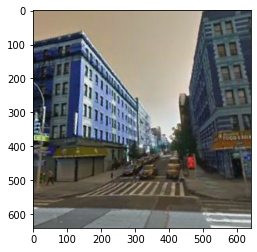

In [11]:
plt.imshow(img)

In [12]:
def update_annots(inpath, outpath):
    with open(inpath, 'r') as fh:
        annots_all = fh.read().splitlines()
    annots_all = [l.split(',') for l in annots_all]
    
    with open(outpath, 'w', newline='') as fh:
        csvwriter = csv.writer(fh)
        for annots in tqdm(annots_all):
            zeni, hori, p0, p1, KR = parse_annot(annots)
            img = cv2.imread(os.path.join(root_db, annots[0]))
            vps = sample_vps(p0, p1, hori, zeni, KR, 2000)
            cx, cy = (img.shape[1] / 2.0, img.shape[0] / 2.0)
            vps[:, 0] += cx
            vps[:, 1] += cy
            if vps[0, 0] > vps[1, 0]:
                vps = vps[::-1, :]
#             
#             plt.imshow(img)
#             plt.scatter(vps[:, 0], vps[:, 1])
#             plt.show()
            
            csvwriter.writerow([annots[0],annots[1],
                                annots[2],annots[3],annots[4],annots[5],
                                vps[0,0],vps[0,1],
                                vps[1,0],vps[1,1]])
#             break

# inpaths = ['gsv_test_20210312.csv',
#            'gsv_val_20210312.csv',
#            'gsv_train_20210312.csv']
# outpaths = ['gsv_test_20210313.csv',
#             'gsv_val_20210313.csv',
#             'gsv_train_20210313.csv']
# for inpath, outpath in zip(inpaths, outpaths):
#     print(inpath)
#     update_annots(inpath, outpath)
# print('done')

In [36]:
root_db = '/data/project/rw/sun360_20200306/'

inpaths = ['sun360_test_20200312.csv',
           'sun360_val_20200312.csv',
           'sun360_train_20200312.csv']
outpaths = ['sun360_test_20210313.csv',
            'sun360_val_20210313.csv',
            'sun360_train_20210313.csv']
for inpath, outpath in zip(inpaths, outpaths):
    print(inpath)
    update_annots(inpath, outpath)
print('done')

  0%|          | 2/878 [00:00<01:00, 14.43it/s]

sun360_test_20200312.csv


  0%|          | 4/815 [00:00<00:24, 32.88it/s]

sun360_val_20200312.csv


  0%|          | 0/30022 [00:00<?, ?it/s]

sun360_train_20200312.csv


100%|██████████| 30022/30022 [22:01<00:00, 22.73it/s]


done


In [33]:
import os.path as osp
osp.exists('/data/project/rw/sun360_manmade/mo/pano_amooumgexgnpjm-3_line.csv')

False

In [34]:
from pylsd import lsd

def decompose_up_vector(v):
    x,y,z = v
    pitch = np.arcsin(z)
    roll = np.arctan(-x/y)
    return pitch, roll

def parse_annot_kitti(annot):
    '''
    annot: [fn_img, focal, rotation matrix]
    '''
    filepath = os.path.join(root_db, annot[0].replace('\\', '/'))
    img = cv2.imread(filepath)
    assert img is not None, print(filepath)
    
    hh, ww = img.shape[:2]
    cx, cy = (ww / 2.0, hh / 2.0)
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    segs_org = lsd(gray, scale=0.5)    
    assert len(segs_org) > 10, print(img_path, len(segs_org))
    
    annot_lines = np.array(segs_org).astype(float)
    annot_lines[:, 0::2] -= cx
    annot_lines[:, 1::2] -= cy
    
    n_seg = len(annot_lines)
    
    p0 = np.hstack([annot_lines[:, :2], np.ones([n_seg, 1])])
    p1 = np.hstack([annot_lines[:, 2:], np.ones([n_seg, 1])])

    rotm = np.float32(annot[2:11])
    rotm = rotm.reshape(3,3).T
    rotm[1,:] = -rotm[1,:]
    gt_up = rotm[:,1]
    
    pitch, roll = decompose_up_vector(gt_up)
    focal = float(annot[1])
    
    R = eul2rotm_ypr([pitch, 0, roll])
    R[1, :] = -R[1, :]
    K = np.array([[focal, 0, 0], [0, focal, 0], [0, 0, 1]])
    KR = np.dot(K, R)
    V = np.dot(KR, np.eye(3))
    
    zeni = V[:, 1] / np.maximum(V[2, 1], 1e-08)
    hori = np.cross(V[:, 0], V[:, 2])
    
    rho = 2.0/np.minimum(ww,hh)
    focal = rho*focal
    
    up_vector = R[:,1]
    hl = up_vector.copy()
    hl[2] = focal*hl[2]
    
    return zeni, hori, p0, p1, KR, hl # (zenith, horizon, line equtions, line lengths)

def update_annots_kitti(inpath, outpath):
    with open(inpath, 'r') as fh:
        annots_all = fh.read().splitlines()
    annots_all = [l.split(',') for l in annots_all]
    
    with open(outpath, 'w', newline='') as fh:
        csvwriter = csv.writer(fh)
        for annots in tqdm(annots_all):
            zeni, hori, p0, p1, KR, hl = parse_annot_kitti(annots)
            img = cv2.imread(os.path.join(root_db, annots[0]))
            vps = sample_vps(p0, p1, hori, zeni, KR, 2000)
            cx, cy = (img.shape[1] / 2.0, img.shape[0] / 2.0)
            vps[:, 0] += cx
            vps[:, 1] += cy
            if vps[0, 0] > vps[1, 0]:
                vps = vps[::-1, :]
                
            csvwriter.writerow([annots[0],annots[1],
                                annots[2],annots[3],annots[4],annots[5],
                                vps[0,0],vps[0,1],
                                vps[1,0],vps[1,1]])

In [35]:
root_db = '/data/public/rw/kitti/20200714/'

inpaths = ['kitti_train_20200714.csv',
           'kitti_train_20200714.csv',
           'kitti_train_20200714.csv']
outpaths = ['kitti_train_20210614.csv',
            'kitti_train_20210614.csv',
            'kitti_train_20210614.csv']
for inpath, outpath in zip(inpaths, outpaths):
    print(inpath)
    update_annots_kitti(inpath, outpath)
print('done')

  0%|          | 0/8675 [00:00<?, ?it/s]

kitti_train_20200714.csv


ValueError: operands could not be broadcast together with shapes (146,4) (146,3) 